In [2]:
# Imports:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import dxchange
import tifffile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
### Load the data
original_data_path = "/dtu/3d-imaging-center/courses/02509/groups/group01/Lava_data/Island_gammel/lavasten_Island_gammel_LFOV-80kV-LE5-4s-45.3micro_recon.txm"
converted_data_path = "/dtu/3d-imaging-center/courses/02509/groups/group01/data/lavasten_Island_gammel_LFOV-80kV-LE5-4s-45.3micro_recon.tiff"

vol_og = dxchange.read_txrm(original_data_path)
vol_new = tifffile.imread(converted_data_path)

print(vol_og[0].shape)
print(vol_new.shape)

print(f"min of original data: {np.min(vol_og[0])}, max of original data: {np.max(vol_og[0])}")
print(f"min of converted data: {np.min(vol_new)}, max of converted data: {np.max(vol_new)}")

(1017, 1024, 1004)
(1017, 1024, 1004)
min of original data: 0, max of original data: 56102
min of converted data: 0, max of converted data: 56102


In [4]:
# Find the amount of voxels needed to represent 0.5 cm
pixel_size = vol_og[1]["pixel_size"]
pixel_amount = int(5000 / pixel_size)

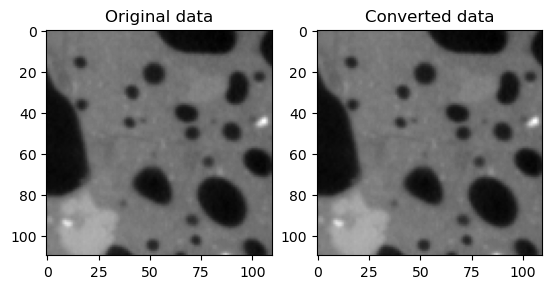

In [5]:
# Plot cropped images
x1 = 410
y1 = 380
z = 400
x2 = x1 + pixel_amount
y2 = y1 + pixel_amount


plt.figure()
plt.subplot(121)
plt.imshow(vol_og[0][x1:x2, y1:y2, z], cmap='gray')
plt.title('Original data')
plt.subplot(122)
plt.imshow(vol_new[x1:x2, y1:y2, z], cmap='gray')
plt.title('Converted data')
plt.show()

# Create cropped data
vol_crop = vol_og[0][x1:x2, y1:y2, z:z+pixel_amount]

The files seem to be the exact same without conversion errors, so we will continue with the txm files.

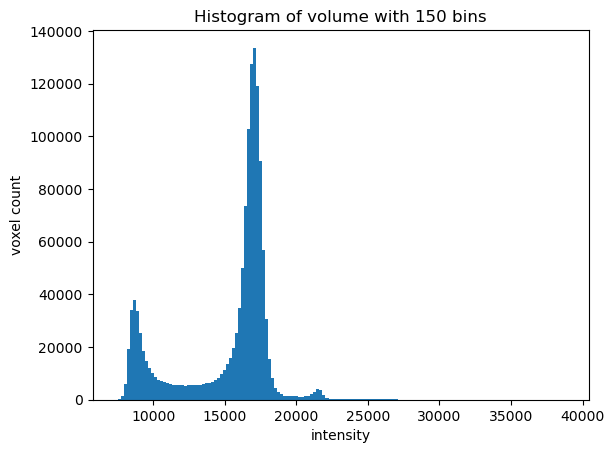

In [5]:
nBins = 150
# your code here
plt.hist(vol_crop.flatten(), nBins)
plt.title('Histogram of volume with '+str(nBins)+' bins')
plt.ylabel('voxel count')
plt.xlabel('intensity')
plt.show()

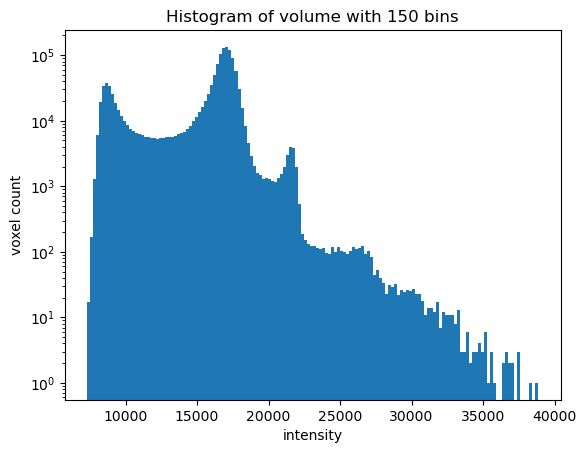

In [6]:
nBins = 150
# your code here
plt.hist(vol_crop.flatten(), nBins)
plt.title('Histogram of volume with '+str(nBins)+' bins')
plt.ylabel('voxel count')
plt.yscale('log')
plt.xlabel('intensity')
plt.show()

global otsu threshold: 13316
global multi otsu thresholds: [13316, 19316]


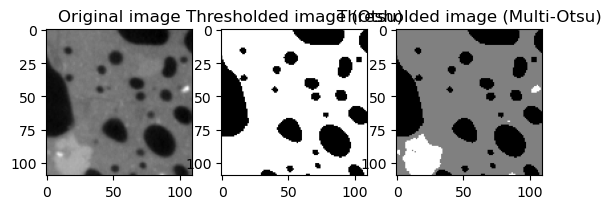

In [7]:
from skimage.filters import threshold_otsu
from skimage.filters import threshold_multiotsu

global_th_otso = threshold_otsu(vol_crop)
#global_th_multiotsu = threshold_multiotsu(vol_crop, classes=4) # Not good at finding the correct threshold
global_th_multiotsu = [global_th_otso, global_th_otso+6000]
print(f"global otsu threshold: {global_th_otso}")
print(f"global multi otsu thresholds: {global_th_multiotsu}")

vol_crop_th_otso = vol_crop >= global_th_otso

vol_crop_th_multiotsu = np.zeros(vol_crop.shape)
for i in range(len(global_th_multiotsu)):
    vol_crop_th_multiotsu += vol_crop >= global_th_multiotsu[i]

plt.figure()
plt.subplot(131)
plt.imshow(vol_crop[:, :, 0], cmap='gray')
plt.title('Original image')
plt.subplot(132)
plt.imshow(vol_crop_th_otso[:, :, 0], cmap='gray')
plt.title('Thresholded image (Otsu)')
plt.subplot(133)
plt.imshow(vol_crop_th_multiotsu[:, :, 0], cmap='gray')
plt.title('Thresholded image (Multi-Otsu)')
plt.show()

In [8]:
# Save the thresholded data
# create new multiotsu threshold, the other was unreliable
vol_th_multiotsu = np.zeros_like(vol_og[0])

mask = (vol_og[0] >= global_th_multiotsu[0]) & (vol_og[0] < global_th_multiotsu[1])
vol_th_multiotsu[mask] = 1
mask = vol_og[0] >= global_th_multiotsu[1]
vol_th_multiotsu[mask] = 2

save_path = '/dtu/3d-imaging-center/courses/02509/groups/group01/segmentations/'
dxchange.write_tiff(vol_th_multiotsu, os.path.join(save_path, 'island_gammel_multimask'))


# Local Thickness

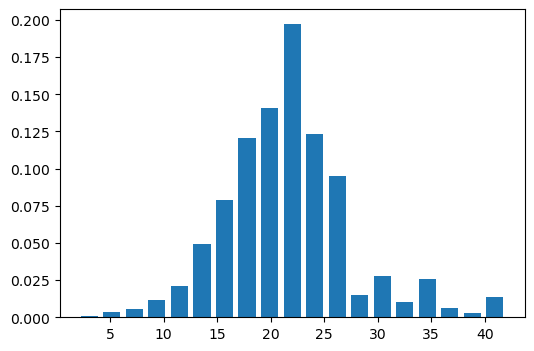

Median: 9.697677612304688  |  Mean: 8.259697914123535


In [9]:
import localthickness as lt

# Compute local thickness on the emanel segmentation using the function lt.local_thickness
thickness = lt.local_thickness(vol_crop_th_otso)
affine = np.array([[1,0,0], [0,1,0], [0,0,1]])

# Save the maximum value of thickness
vmax = np.max(thickness)

# Compute the histogram of the thickness7
histThk,binsThk = np.histogram(thickness.flatten(), bins=int(np.floor(vmax)-1), range=(1,np.ceil(vmax)), density=True)

# Compute the center of each bean
binsThkCent = binsThk[0:-1] + np.divide(binsThk[1:]-binsThk[0:-1],2)

# Plot the histogram as a bar plot for a better representation
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.bar(binsThkCent*affine[0,0]*2, histThk, width=0.8*affine[0,0]*2)

plt.show()

# Compute median and mean value of the thickness
t = thickness.flatten()
medianThick = np.median(t)
meanThick = np.mean(t)
print(f'Median: {medianThick}  |  Mean: {meanThick}')

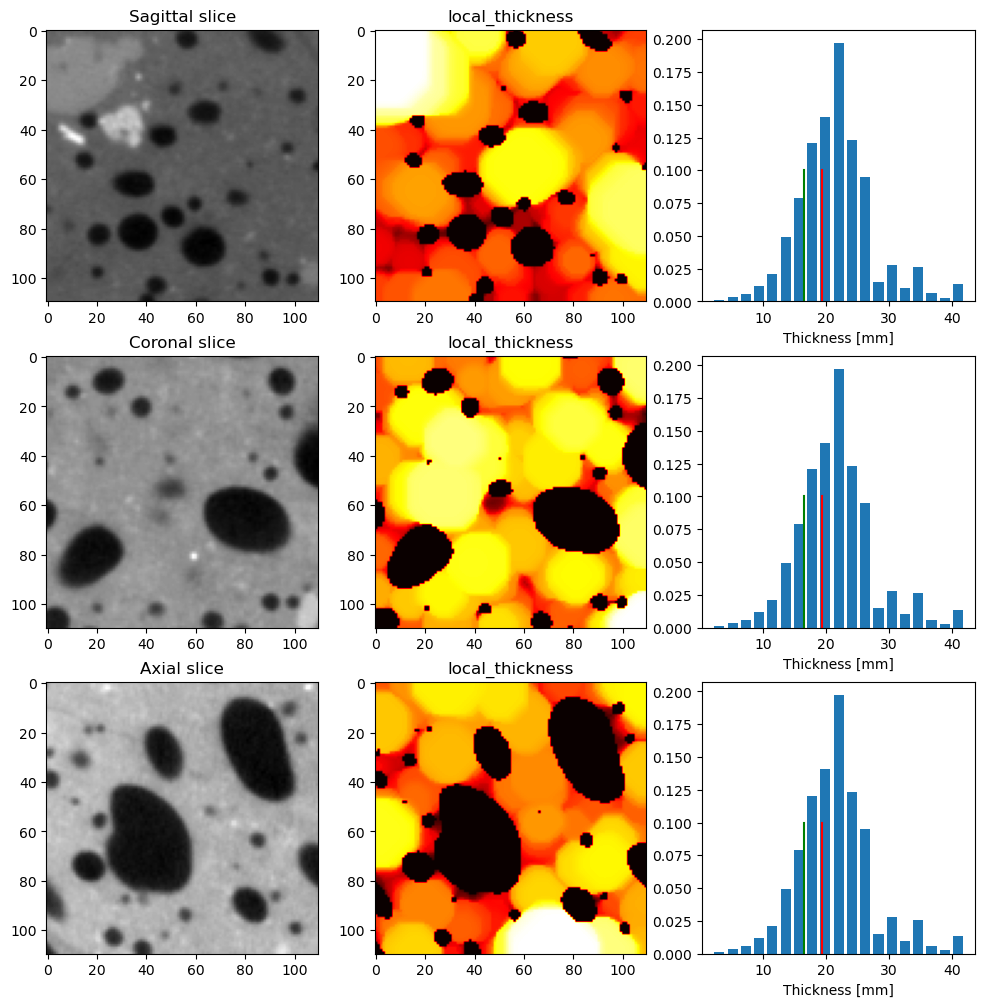

In [10]:
slice_n = 100 

#----------------Sagittal slice----------------
fig, ax = plt.subplots(3,3,figsize=(12,12))
ax[0][0].imshow(np.squeeze(vol_crop[slice_n,:,:]), cmap='gray')
ax[0][0].set_title('Sagittal slice')

ax[0][1].imshow(np.squeeze(thickness[slice_n,:,:]), cmap='hot')
ax[0][1].set_title('local_thickness')

ax[0][2].bar(binsThkCent*affine[0,0]*2,histThk, width=0.8*affine[0,0]*2)
ax[0][2].plot(np.array([medianThick, medianThick])*affine[0,0]*2, np.array([0.0, 0.1]),'r')
ax[0][2].plot(np.array([meanThick, meanThick])*affine[0,0]*2, np.array([0.0, 0.1]),'g')
ax[0][2].set_xlabel('Thickness [mm]')


#----------------Coronal view----------------

ax[1][0].imshow(np.squeeze(vol_crop[:,slice_n,:]), cmap='gray')
ax[1][0].set_title('Coronal slice')

ax[1][1].imshow(np.squeeze(thickness[:,slice_n,:]), cmap='hot')
ax[1][1].set_title('local_thickness')

ax[1][2].bar(binsThkCent*affine[0,0]*2,histThk, width=0.8*affine[0,0]*2)
ax[1][2].plot(np.array([medianThick, medianThick])*affine[0,0]*2, np.array([0.0, 0.1]),'r')
ax[1][2].plot(np.array([meanThick, meanThick])*affine[0,0]*2, np.array([0.0, 0.1]),'g')
ax[1][2].set_xlabel('Thickness [mm]')


#----------------Axial view----------------

ax[2][0].imshow(np.squeeze(vol_crop[:,:,slice_n]), cmap='gray')
ax[2][0].set_title('Axial slice')

ax[2][1].imshow(np.squeeze(thickness[:,:,slice_n]), cmap='hot')
ax[2][1].set_title('local_thickness')

ax[2][2].bar(binsThkCent*affine[0,0]*2,histThk, width=0.8*affine[0,0]*2)
ax[2][2].plot(np.array([medianThick, medianThick])*affine[0,0]*2, np.array([0.0, 0.1]),'r')
ax[2][2].plot(np.array([meanThick, meanThick])*affine[0,0]*2, np.array([0.0, 0.1]),'g')
ax[2][2].set_xlabel('Thickness [mm]')

plt.show()

# Local Thickness (full volume)

Thickness file exists, loading...


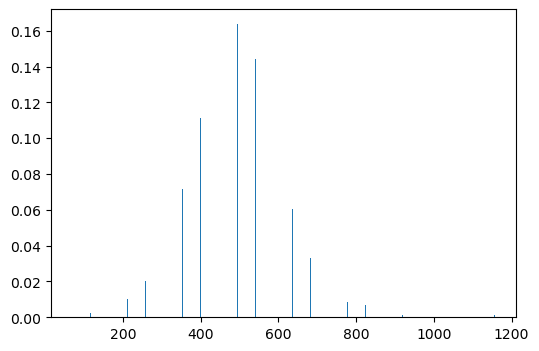

Median: 0.0  |  Mean: 0.9311959147453308


In [11]:
vol_th_otso = vol_og[0] >= global_th_otso

# Compute local thickness on the emanel segmentation using the function lt.local_thickness
if not os.path.exists(os.path.join('/dtu/3d-imaging-center/courses/02509/groups/group01/other/', 'island_gammel_thickness.tiff')):
    print("Thickness file doesn't exist, creating new...")
    thickness = lt.local_thickness(vol_th_otso)
else:
    print("Thickness file exists, loading...")
    thickness = dxchange.read_tiff(os.path.join('/dtu/3d-imaging-center/courses/02509/groups/group01/other/', 'island_gammel_thickness.tiff'))
affine = np.array([[1,0,0], [0,1,0], [0,0,1]])

# Save the maximum value of thickness
vmax = np.max(thickness)

# Compute the histogram of the thickness7
histThk,binsThk = np.histogram(thickness.flatten(), bins=int(np.floor(vmax)-1), range=(1,np.ceil(vmax)), density=True)

# Compute the center of each bean
binsThkCent = binsThk[0:-1] + np.divide(binsThk[1:]-binsThk[0:-1],2)

# Plot the histogram as a bar plot for a better representation
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.bar(binsThkCent*affine[0,0]*pixel_size, histThk, width=0.8*affine[0,0]*2)

plt.show()

# Compute median and mean value of the thickness
t = thickness.flatten()
medianThick = np.median(t)
meanThick = np.mean(t)
print(f'Median: {medianThick}  |  Mean: {meanThick}')

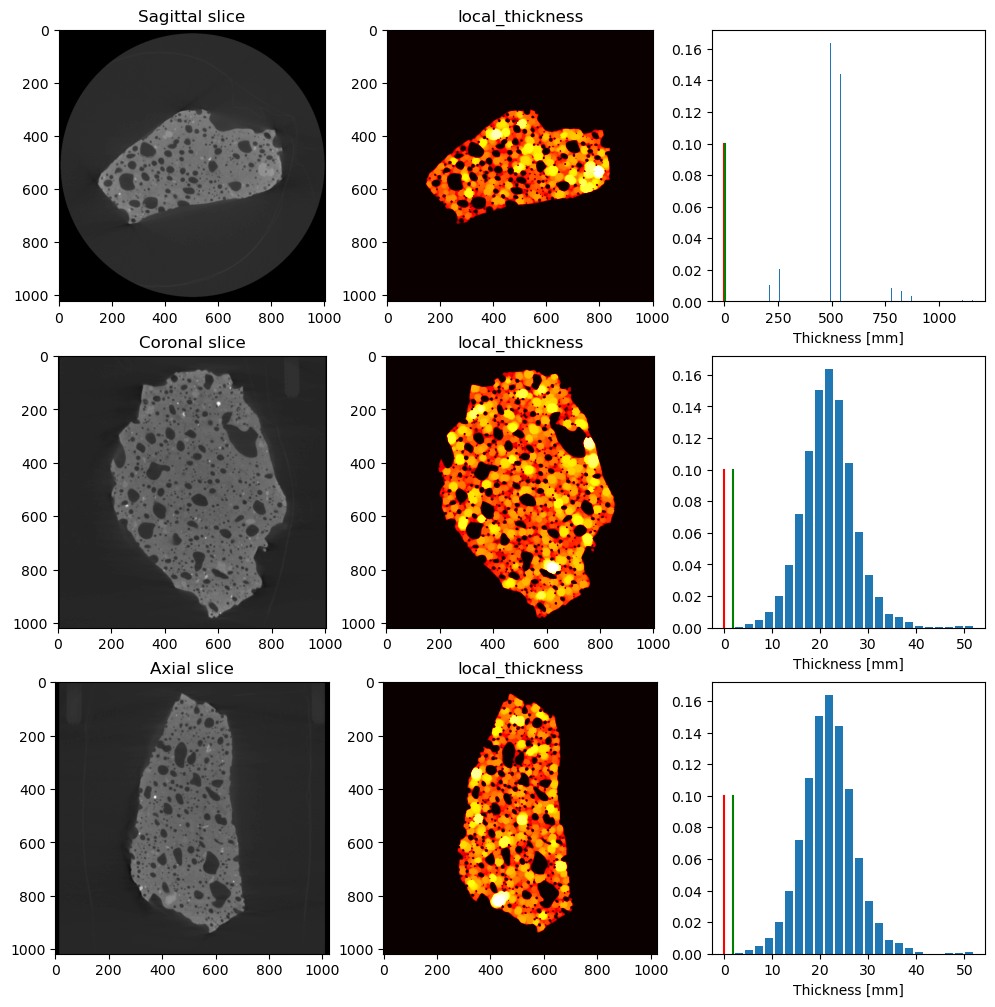

In [12]:
slice_n = 500 

#----------------Sagittal slice----------------
fig, ax = plt.subplots(3,3,figsize=(12,12))
ax[0][0].imshow(np.squeeze(vol_og[0][slice_n,:,:]), cmap='gray')
ax[0][0].set_title('Sagittal slice')

ax[0][1].imshow(np.squeeze(thickness[slice_n,:,:]), cmap='hot')
ax[0][1].set_title('local_thickness')

ax[0][2].bar(binsThkCent*affine[0,0]*pixel_size,histThk, width=0.8*affine[0,0]*2)
ax[0][2].plot(np.array([medianThick, medianThick])*affine[0,0]*2, np.array([0.0, 0.1]),'r')
ax[0][2].plot(np.array([meanThick, meanThick])*affine[0,0]*2, np.array([0.0, 0.1]),'g')
ax[0][2].set_xlabel('Thickness [mm]')


#----------------Coronal view----------------

ax[1][0].imshow(np.squeeze(vol_og[0][:,slice_n,:]), cmap='gray')
ax[1][0].set_title('Coronal slice')

ax[1][1].imshow(np.squeeze(thickness[:,slice_n,:]), cmap='hot')
ax[1][1].set_title('local_thickness')

ax[1][2].bar(binsThkCent*affine[0,0]*2,histThk, width=0.8*affine[0,0]*2)
ax[1][2].plot(np.array([medianThick, medianThick])*affine[0,0]*2, np.array([0.0, 0.1]),'r')
ax[1][2].plot(np.array([meanThick, meanThick])*affine[0,0]*2, np.array([0.0, 0.1]),'g')
ax[1][2].set_xlabel('Thickness [mm]')


#----------------Axial view----------------

ax[2][0].imshow(np.squeeze(vol_og[0][:,:,slice_n]), cmap='gray')
ax[2][0].set_title('Axial slice')

ax[2][1].imshow(np.squeeze(thickness[:,:,slice_n]), cmap='hot')
ax[2][1].set_title('local_thickness')

ax[2][2].bar(binsThkCent*affine[0,0]*2,histThk, width=0.8*affine[0,0]*2)
ax[2][2].plot(np.array([medianThick, medianThick])*affine[0,0]*2, np.array([0.0, 0.1]),'r')
ax[2][2].plot(np.array([meanThick, meanThick])*affine[0,0]*2, np.array([0.0, 0.1]),'g')
ax[2][2].set_xlabel('Thickness [mm]')

plt.savefig('/dtu/3d-imaging-center/courses/02509/groups/members/tobias_s183478/Project/island_gammel_full_thickness.png')

In [13]:
save_path = '/dtu/3d-imaging-center/courses/02509/groups/group01/other/'
if not os.path.exists(os.path.join('/dtu/3d-imaging-center/courses/02509/groups/group01/other/', 'island_gammel_thickness.tiff')):
    dxchange.write_tiff(thickness, os.path.join(save_path, 'island_gammel_thickness'))

# Closing of mask

In [6]:
import nibabel as nib
from skimage.morphology import closing, cube
mask = nib.load("/dtu/3d-imaging-center/courses/02509/groups/group01/segmentations/island_gammel_contour_mask.nii.gz").get_fdata()

In [7]:
closed_mask = closing(mask, cube(41))

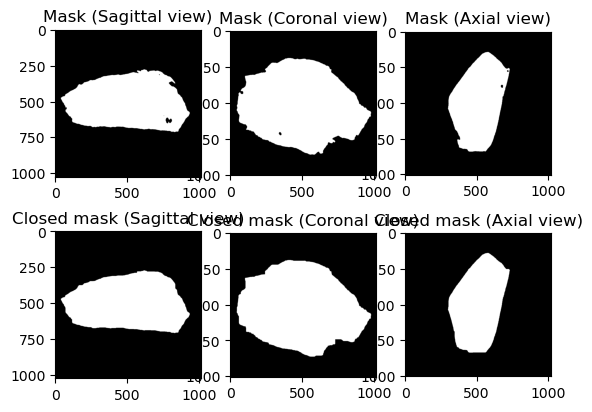

In [8]:
slice_n = 500
plt.figure()
plt.subplot(231)
plt.imshow(mask[slice_n, :, :], cmap='gray')
plt.title('Mask (Sagittal view)')
plt.subplot(232)
plt.imshow(mask[:, slice_n, :], cmap='gray')
plt.title('Mask (Coronal view)')
plt.subplot(233)
plt.imshow(mask[:, :, slice_n], cmap='gray')
plt.title('Mask (Axial view)')
plt.subplot(234)
plt.imshow(closed_mask[slice_n, :, :], cmap='gray')
plt.title('Closed mask (Sagittal view)')
plt.subplot(235)
plt.imshow(closed_mask[:, slice_n, :], cmap='gray')
plt.title('Closed mask (Coronal view)')
plt.subplot(236)
plt.imshow(closed_mask[:, :, slice_n], cmap='gray')
plt.title('Closed mask (Axial view)')

plt.show()


In [9]:
#nib.save(nib.Nifti1Image(closed_mask, np.eye(4)), '/dtu/3d-imaging-center/courses/02509/groups/group01/segmentations/island_gammel_contour_mask_closed.nii.gz')

# Test of sample extractor

In [9]:
import os
os.chdir("/dtu/3d-imaging-center/courses/02509/groups/members/tobias_s183478/Project/HPC3D_project")
import sample_extractor as se

In [10]:

print(vol_og[1].keys())
data_org_vol = vol_og[0]
pixel_size = vol_og[1]['pixel_size']
print("pixel_size: ", pixel_size)
img_shape = data_org_vol.shape
print("img_shape: ", img_shape)
img_shape_array = np.array(img_shape)
total_size = img_shape_array * pixel_size
total_size__mm = total_size/1000
print("total_size_mm: ", total_size__mm)
pixel_size_mm = pixel_size/1000
pixels_per_mm = 1/pixel_size_mm
print("pixels_per_mm: ", pixels_per_mm)

dict_keys(['facility', 'image_width', 'image_height', 'data_type', 'number_of_images', 'pixel_size', 'reference_filename', 'reference_data_type', 'thetas', 'x_positions', 'y_positions', 'z_positions', 'x-shifts', 'y-shifts', 'reference'])
pixel_size:  45.34814453125
img_shape:  (1017, 1024, 1004)
total_size_mm:  [46.11906299 46.4365     45.52953711]
pixels_per_mm:  22.051618877391707


(1017, 1024, 1004)
(1017, 1024, 1004)


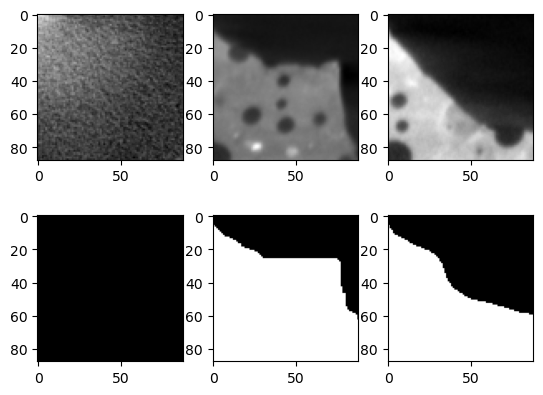

In [11]:
# plot an example section
if closed_mask.shape != vol_og[0].shape:
    closed_mask = closed_mask.T

# sanity check
assert closed_mask.shape == vol_og[0].shape    
print(closed_mask.shape)
print(vol_og[0].shape)

grid_list = se.extract_samples(mask=closed_mask,
                               pixels_per_mm=pixels_per_mm,
                               mm_per_grid=4,
                               discard_threshold=0.33)


grid_dict = grid_list[10]
slice_n = 0
plt.figure()
plt.subplot(231)
plt.imshow(se.apply_grid(volume=vol_og[0], grid_dict=grid_dict)[slice_n,:, :], cmap='gray')
plt.subplot(232)
plt.imshow(se.apply_grid(volume=vol_og[0], grid_dict=grid_dict)[:,slice_n, :], cmap='gray')
plt.subplot(233)
plt.imshow(se.apply_grid(volume=vol_og[0], grid_dict=grid_dict)[:,:, slice_n], cmap='gray')
plt.subplot(234)
plt.imshow(se.apply_grid(volume=closed_mask, grid_dict=grid_dict)[slice_n, : ,:], cmap='gray', vmin=0, vmax=1)
plt.subplot(235)
plt.imshow(se.apply_grid(volume=closed_mask, grid_dict=grid_dict)[:, slice_n, :], cmap='gray', vmin=0, vmax=1)
plt.subplot(236)
plt.imshow(se.apply_grid(volume=closed_mask, grid_dict=grid_dict)[:,:, slice_n], cmap='gray', vmin=0, vmax=1)
plt.show()

(1017, 1024, 1004)


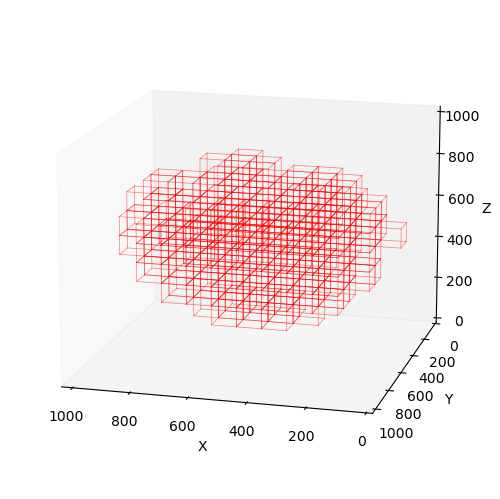

In [13]:
save_path = "/dtu/3d-imaging-center/courses/02509/groups/group01/other/"
print(closed_mask.shape)
#Note: Try and get the exact camera data for use with tomviz
se.plot_samples(closed_mask, grid_list, view=(0, 0), linewidth=0.5, alpha=0.5, save_path=save_path)

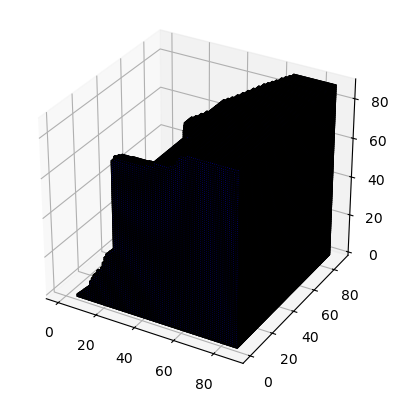

In [21]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(se.apply_grid(volume=closed_mask, grid_dict=grid_dict), facecolors='blue', edgecolor='k')
ax.set_aspect('equal')
ax.view_init(30, -60) 
plt.show()